In [1]:
import numpy as np  # import numpy library

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Defining a function to load and split the data. It will return the train and test data after normalizing the features.
def load_spam_data():
    # Reading the data from a file named "spambase.data" from data folder
    data = []
    with open("../data/spambase.data") as file_in:
        for line in file_in:
            row = []
            elements = line.split(',')
            for num in range(len(elements)):
                if(num < (len(elements)-1)):
                    row.append(float(elements[num]))
                else:
                    row.append(int(elements[num]))
            data.append(row) 
        
    # Extracting the feature names from a file named "spambase.names" from data folder
    variable_names = []
    with open("../data/spambase.names") as file_in:
        for line in file_in:
            if('|' not in line and ':' in line and 'continuous' in line):
                name = line.split(':')
                variable_names.append(name[0])
    variable_names.append("Class_label")
    
    # Create the pandas DataFrame from 'data' list and 'variable_names' list 
    df = pd.DataFrame(data, columns = variable_names)
    # Separating target variable 
    target_df = df['Class_label']
    # Dropping the 'Class_label' column from the dataframe
    data_df = df.drop(['Class_label'], axis=1)
    # Splitting the data into train_data and test_data
    X_train, X_test, Y_train, Y_test = train_test_split(data_df, target_df, test_size=0.2, random_state=0)
    # Normalizing the features. Here we have normalized data to convert all the features to same scale
    sc = StandardScaler()
    X_train_standardized = sc.fit_transform(X_train)
    X_test_standardized = sc.transform(X_test)
    
    # Returning the train data and test data
    return (X_train_standardized,Y_train),(X_test_standardized,Y_test)

In [4]:
# Calling the 'load_spam_data' function
(data_train,label_train),(X_test,Y_test) = load_spam_data()

# Splitting the training data into train and validation data
X_train = data_train[:3080]
Y_train = label_train[:3080]
X_validate = data_train[3080:]
Y_validate = label_train[3080:]

print("Shape of X_train : ",X_train.shape)
print("Shape of Y_train : ",Y_train.shape)
print("Shape of X_validate : ",X_validate.shape)
print("Shape of Y_validate : ",Y_validate.shape)
print("Shape of X_test : ",X_test.shape)
print("Shape of Y_test : ",Y_test.shape)

Shape of X_train :  (3080, 57)
Shape of Y_train :  (3080,)
Shape of X_validate :  (600, 57)
Shape of Y_validate :  (600,)
Shape of X_test :  (921, 57)
Shape of Y_test :  (921,)


In [5]:
# This class includes y = W0+W1*X1+W2*X2
class LinearLayer:
    """
        This Class implements all functions to be executed by a linear layer
        in a computational graph
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
                      Opitons are: plain, xavier and he
        Methods:
            forward(A_prev)
            backward(upstream_grad)
            update_params(learning_rate)
    """

    def __init__(self, input_shape, n_out):
        """
        The constructor of the LinearLayer takes the following parameters
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
        """

        self.m = input_shape[1]  # number of examples in training data
        # `params` store weights and bias in a python dictionary
        self.params = {'W': np.random.randn(input_shape[1], n_out), 'b': np.random.randn(n_out)}  # initialize weights and bias
        self.Z = np.zeros((input_shape[0], n_out))  # create space for resultant Z output

    def forward(self, A_prev):
        """
        This function performs the forwards propagation using activations from previous layer
        Args:
            A_prev:  Activations/Input Data coming into the layer from previous layer
        """

        self.A_prev = A_prev  # store the Activations/Training Data coming in
        self.Z = np.dot( self.A_prev, self.params['W']) + self.params['b']  # compute the linear function

    def backward(self, upstream_grad):
        """
        This function performs the back propagation using upstream gradients
        Args:
            upstream_grad: gradient coming in from the upper layer to couple with local gradient
        """

        # derivative of Cost w.r.t W
        self.dW = np.dot(self.A_prev.T, upstream_grad)

        # derivative of Cost w.r.t b, sum across rows
        self.db = np.sum(upstream_grad, axis=0, keepdims=True)

        # derivative of Cost w.r.t A_prev
        self.dA_prev = np.dot(upstream_grad, self.params['W'].T)

    def update_params(self, learning_rate=0.1):
        """
        This function performs the gradient descent update
        Args:
            learning_rate: learning rate hyper-param for gradient descent, default 0.1
        """

        self.params['W'] = self.params['W'] - learning_rate * self.dW  # update weights
        self.params['b'] = self.params['b'] - learning_rate * self.db  # update bias(es)
    

In [6]:
class SigmoidLayer:
    """
    This file implements activation layers
    inline with a computational graph model
    Args:
        shape: shape of input to the layer
    Methods:
        forward(Z)
        backward(upstream_grad)
    """

    def __init__(self, shape):
        """
        The consturctor of the sigmoid/logistic activation layer takes in the following arguments
        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function
        Args:
            Z: input from previous (linear) layer
        """
        self.A = 1 / (1 + np.exp(-Z))  # compute activations

    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of sigmoid => A*(1-A)
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad * self.A*(1-self.A)

In [21]:
def compute_cost(Y, Y_hat):
    """
    This function computes and returns the Cost and its derivative.
    The is function uses the binary cross-entropy loss -> -(y*log(Y_hat)+(1-y)log(1-Y_hat))
    Args:
        Y: labels of data
        Y_hat: Predictions(activations) from a last layer, the output layer
    Returns:
        cost: Binary cross-entropy loss
        dY_hat: gradient of Cost w.r.t the Y_hat
    """

    cost = 0
    m = Y.shape[0]
    #epsilon = 1
    # Adding epsilon = 1e^-8 to Y_hat
    Y_hat = Y_hat
    for true, pred in zip(Y, Y_hat):
        cost += (-(true * np.log(pred) + (1.0-true) * np.log(1.0 - pred)))
    cost = np.squeeze(cost)/m  # remove extraneous dimensions to give just a scalar

    dY_hat = 0
    for true, pred in zip(Y, Y_hat):
        dY_hat += (-((true/pred) - ((1.0-true)/(1.0 - pred))))
    dY_hat = np.squeeze(dY_hat)/m
    
    # Gradient clipping for exploding gradient
    while(dY_hat > 10 or dY_hat < -10):
        dY_hat /= 10

    return cost, dY_hat

In [22]:
# Evaluation function : accuracy
def accuracy(Y, Y_hat):
    m = Y.shape[0]
    true_pred_count = 0
    for true,pred in zip(Y, Y_hat):
        if(true == 1 and pred >= 0.5) or (true == 0 and pred < 0.5):
            true_pred_count += 1
            
    return (true_pred_count/m)        

#### Designing the network with 2 hidden layers and output layer

In [76]:
# Our network architecture has the shape: 
#                   (input)--> [Linear->Sigmoid] -> [Linear->Sigmoid] --> [Linear->Softmax] -->(output)  

#------ LAYER-1 ----- define 1st hidden layer that takes in training data 
Z1 = LinearLayer(input_shape=X_train.shape, n_out=10)
A1 = SigmoidLayer(Z1.Z.shape)

#------ LAYER-2 ----- define 2nd hidden layer that take its values from hidden layer
Z2= LinearLayer(input_shape=A1.A.shape, n_out=10)
A2= SigmoidLayer(Z2.Z.shape)

#------ LAYER-3 ----- define output layer that take its values from hidden layer
Z3= LinearLayer(input_shape=A2.A.shape, n_out=1)
A3= SigmoidLayer(Z3.Z.shape)

In [77]:
# define training constants
learning_rate = 0.000005
number_of_epochs = 201

train_loss = []# initially empty list, this will store all the costs after a certian number of epochs
train_accuracy = []
val_loss = []
val_accuracy = []

# Start training
for epoch in range(number_of_epochs):
    
    # ------------------------- forward-pass -------------------------
    Z1.forward(X_train)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    Z3.forward(A2.A)
    A3.forward(Z3.Z)    
    
    # ---------------------- Compute Cost ----------------------------
    cost, dA3 = compute_cost(Y=Y_train, Y_hat=A3.A)
    # Train accuracy
    acc = accuracy(Y_train, A3.A)
    #print(dA3)
    
    # ------------------------- backward-pass ----------------------------
    A3.backward(dA3)

    Z3.backward(A3.dZ)
    
    A2.backward(Z3.dA_prev)

    Z2.backward(A2.dZ)

    A1.backward(Z2.dA_prev)

    Z1.backward(A1.dZ)
    
    # ----------------------- Update weights and bias ----------------
    Z3.update_params(learning_rate=learning_rate)
    Z2.update_params(learning_rate=learning_rate)
    Z1.update_params(learning_rate=learning_rate)
    
    # Validation data
    # ------------------------- forward-pass -------------------------
    Z1.forward(X_validate)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    Z3.forward(A2.A)
    A3.forward(Z3.Z)    
    
    # ---------------------- Compute Cost ----------------------------
    val_cost, dA3 = compute_cost(Y=Y_validate, Y_hat=A3.A)
    # Validation accuracy
    val_acc = accuracy(Y_validate, A3.A)    
    

    # print and store Costs every 10 iterations.
    if (epoch % 10) == 0:
        #print("Cost at epoch#" + str(epoch) + ": " + str(cost))
        
        
        print("Epoch#{0}: Train_loss = {1:.5f}; Train_accuracy = {2:.5f}; Val_loss = {3:.5f}; Val_accuracy = {4:.5f}".format(epoch, cost,acc,val_cost,val_acc))
        #print(dA3)
        
        #print(A3.A[0:10])
        train_loss.append(cost)
        train_accuracy.append(acc)
        val_loss.append(val_cost)
        val_accuracy.append(val_acc)

Epoch#0: Train_loss = 1.76861; Train_accuracy = 0.38831; Val_loss = 1.76921; Val_accuracy = 0.39000
Epoch#10: Train_loss = 1.72885; Train_accuracy = 0.38831; Val_loss = 1.72929; Val_accuracy = 0.39000
Epoch#20: Train_loss = 1.69016; Train_accuracy = 0.38831; Val_loss = 1.69044; Val_accuracy = 0.39000
Epoch#30: Train_loss = 1.65253; Train_accuracy = 0.38831; Val_loss = 1.65265; Val_accuracy = 0.39000
Epoch#40: Train_loss = 1.61597; Train_accuracy = 0.38831; Val_loss = 1.61593; Val_accuracy = 0.39000
Epoch#50: Train_loss = 1.58046; Train_accuracy = 0.38831; Val_loss = 1.58027; Val_accuracy = 0.39000
Epoch#60: Train_loss = 1.35089; Train_accuracy = 0.38799; Val_loss = 1.32499; Val_accuracy = 0.39000
Epoch#70: Train_loss = 1.11884; Train_accuracy = 0.39091; Val_loss = 1.09978; Val_accuracy = 0.39667
Epoch#80: Train_loss = 0.96211; Train_accuracy = 0.40422; Val_loss = 0.94825; Val_accuracy = 0.41833
Epoch#90: Train_loss = 0.85818; Train_accuracy = 0.42597; Val_loss = 0.84806; Val_accuracy =

#### Plot the training and validation loss as a function of epochs. Plot the training and validation accuracy as a function of epochs

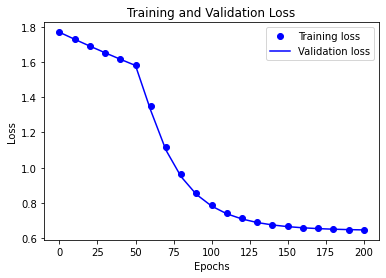

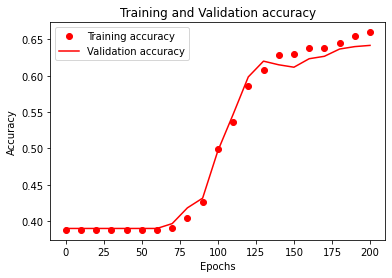

In [78]:
import matplotlib.pyplot as plt

epochs = range(0, 201, 10)

# Plot loss plot 
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy plot 
plt.plot(epochs, train_accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Evaluating on the test data :

In [79]:
# Making predictions on test data
# ------------------------- forward-pass -------------------------
Z1.forward(X_test)
A1.forward(Z1.Z)
    
Z2.forward(A1.A)
A2.forward(Z2.Z)
    
Z3.forward(A2.A)
A3.forward(Z3.Z)

In [80]:
print("Test Accuracy : ",accuracy(Y_test, A3.A)*100)

Test Accuracy :  63.952225841476654


In [81]:
print("Test Loss : ",compute_cost(Y_test, A3.A)[0])

Test Loss :  0.6658268904603042
